# IPO Performance Prediction

## Introduction

This notebook presents an analysis to predict the first-quarter performance of IPOs. The project is structured using a Python backend. It is run on ipo_data.csv which is generated using generate_data.py script.

In [1]:
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Add the project root to the Python path to allow for module imports
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from ipo_analysis.ipo_analyzer.analysis_pipeline import AnalysisPipeline
from ipo_analysis.ipo_analyzer.config import TARGET_COLUMN, Columns, Models

# Set plot style and display options for the notebook
sns.set(style="whitegrid")
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

## 1. Exploratory Data Analysis (EDA)

First, the data is loaded & cleaned. This involves handling missing values and understanding the basic structure and distributions of the dataset.

In [2]:
pipeline = AnalysisPipeline(data_file_path='ipo_data.csv')
pipeline.load_and_clean_data()

--- Loading and Cleaning Data ---
Loading data from: ipo_data.csv
Data loaded successfully.
Dropped 47 rows with missing target variable ('q1_return').
Data loading and cleaning complete.


### Missing Data Analysis

Fraction of missing data per feature:


,missing_fraction
underwriter_rank,0.1200
sector_performance_30d,0.1175
industry_sector,0.1175
q1_return,0.1175
employees,0.1150
venture_backed,0.1100
company_age,0.0975
shares_offered_millions,0.0950
revenue_millions,0.0950
ebitda_margin,0.0950


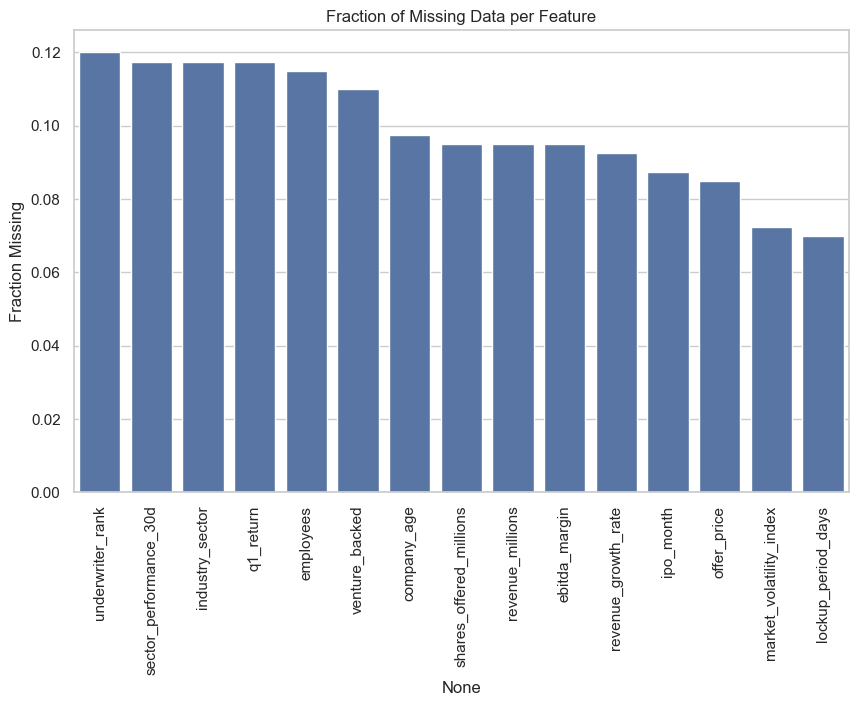

In [3]:
missing_data_df = pipeline.get_missing_data_fraction()
print("Fraction of missing data per feature:")
display(missing_data_df)

plt.figure(figsize=(10, 6))
sns.barplot(x=missing_data_df.index, y=missing_data_df['missing_fraction'])
plt.xticks(rotation=90)
plt.title('Fraction of Missing Data per Feature')
plt.ylabel('Fraction Missing')
plt.show()

**Discussion:** Several features have missing data. To prevent data leakage, feature imputation will be done inside the final modeling pipeline, which runs after the data has been split into training and test sets. This ensures that information from the test set (like its median) is not used to fill in missing values in the training set.

### Individual Feature Distributions

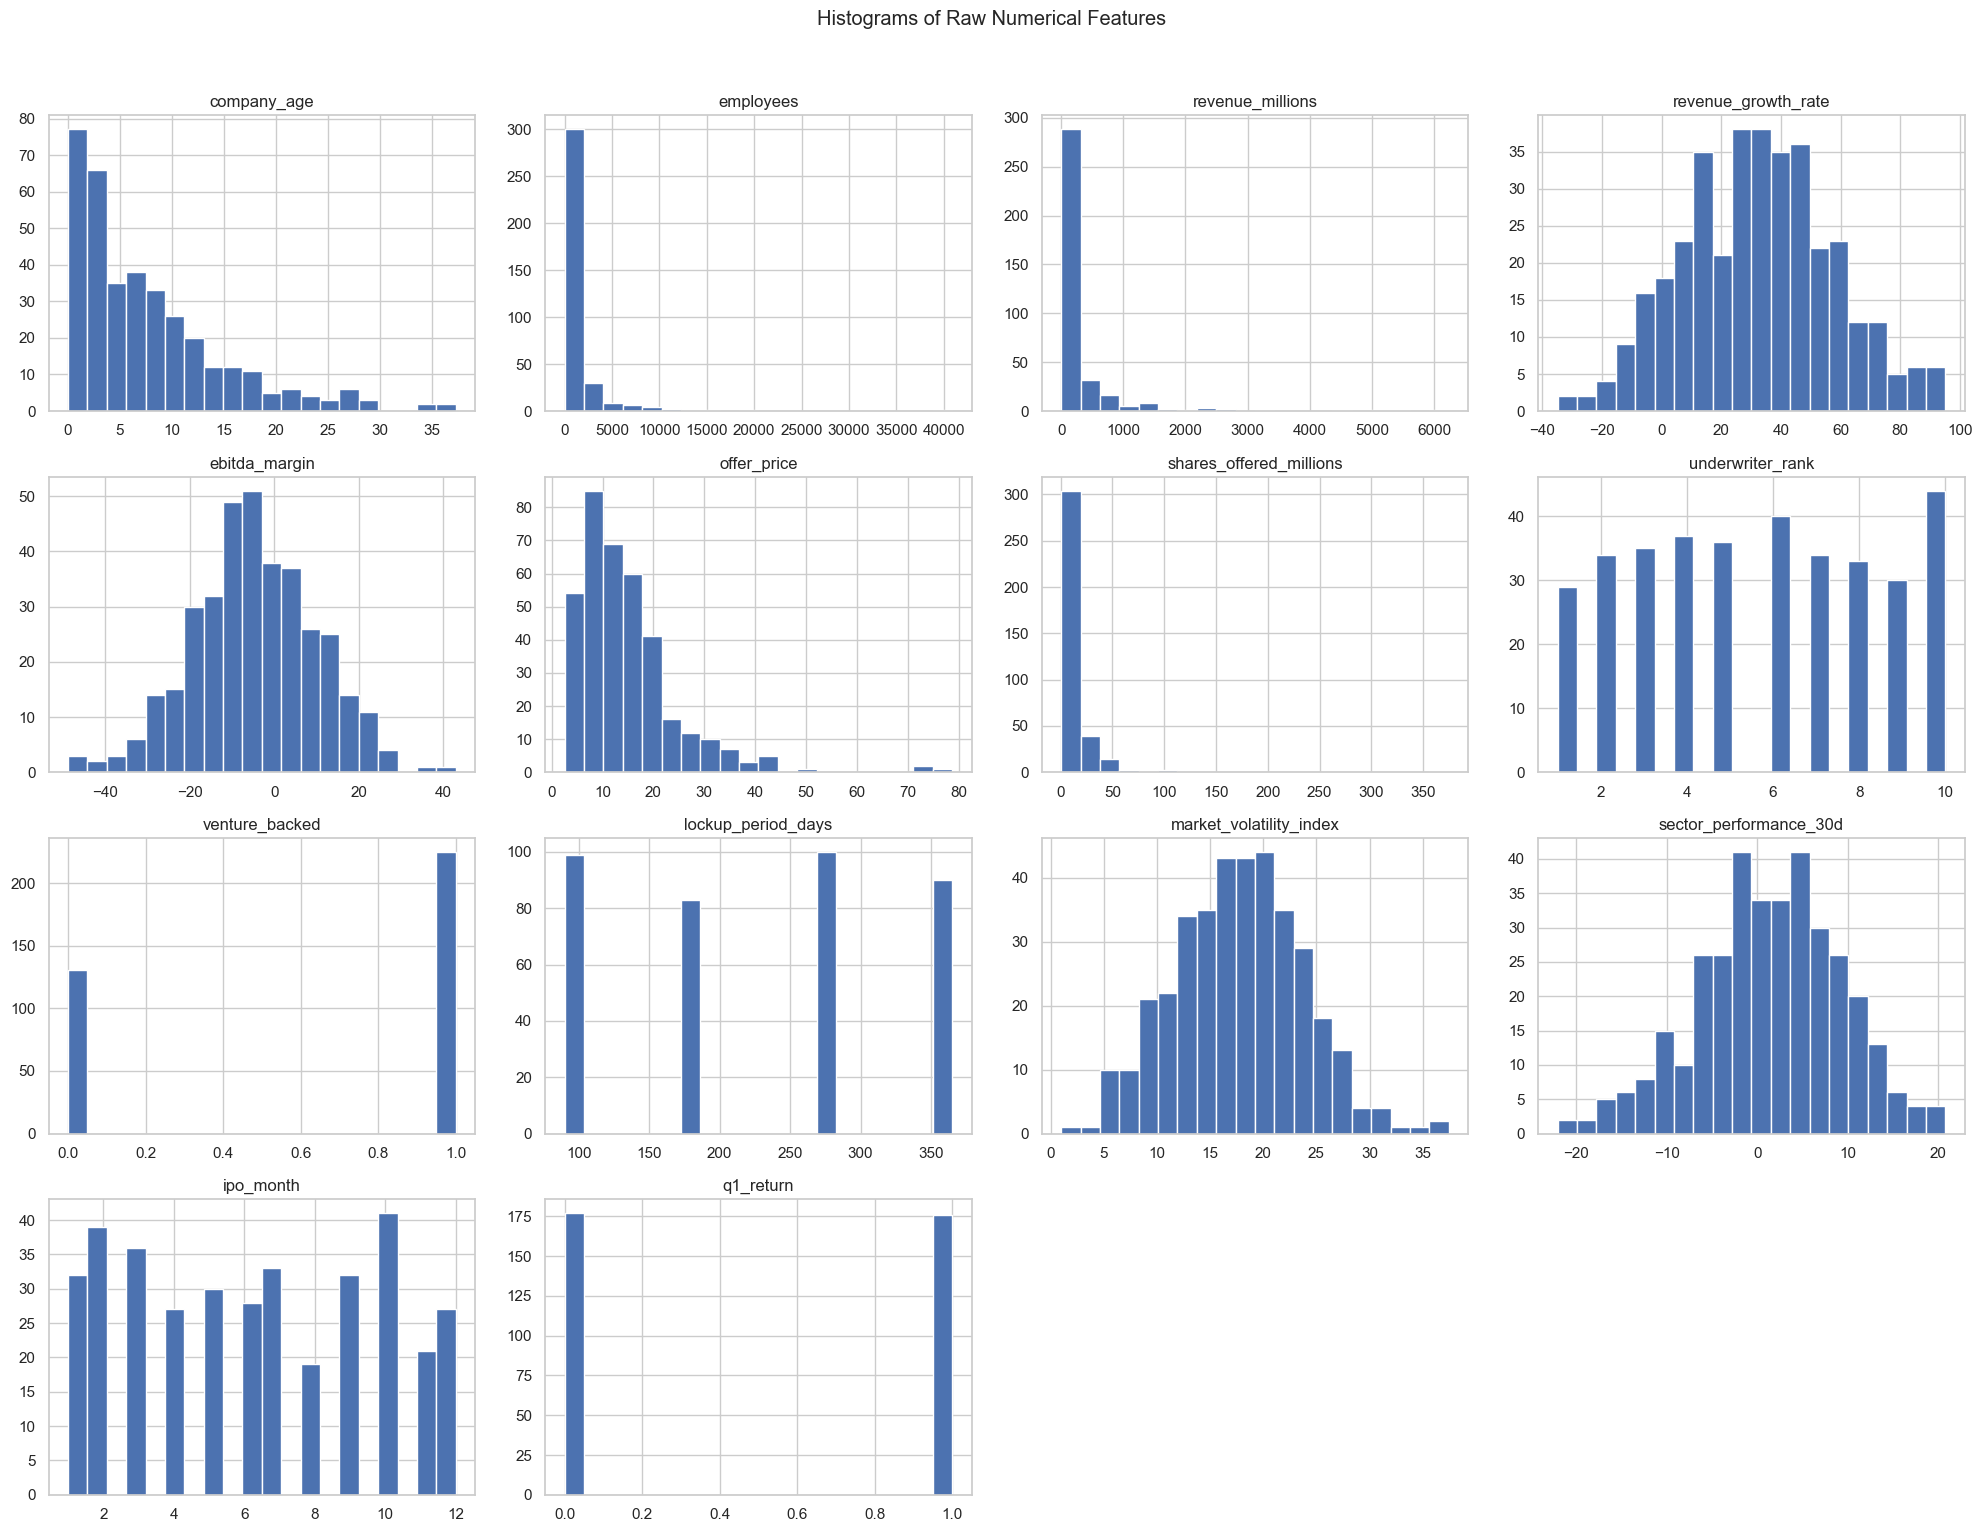

In [4]:
pipeline.raw_df.hist(bins=20, figsize=(20, 15))
plt.suptitle('Histograms of Raw Numerical Features', y=1.02)
plt.tight_layout()
plt.show()

### Target Variable Analysis

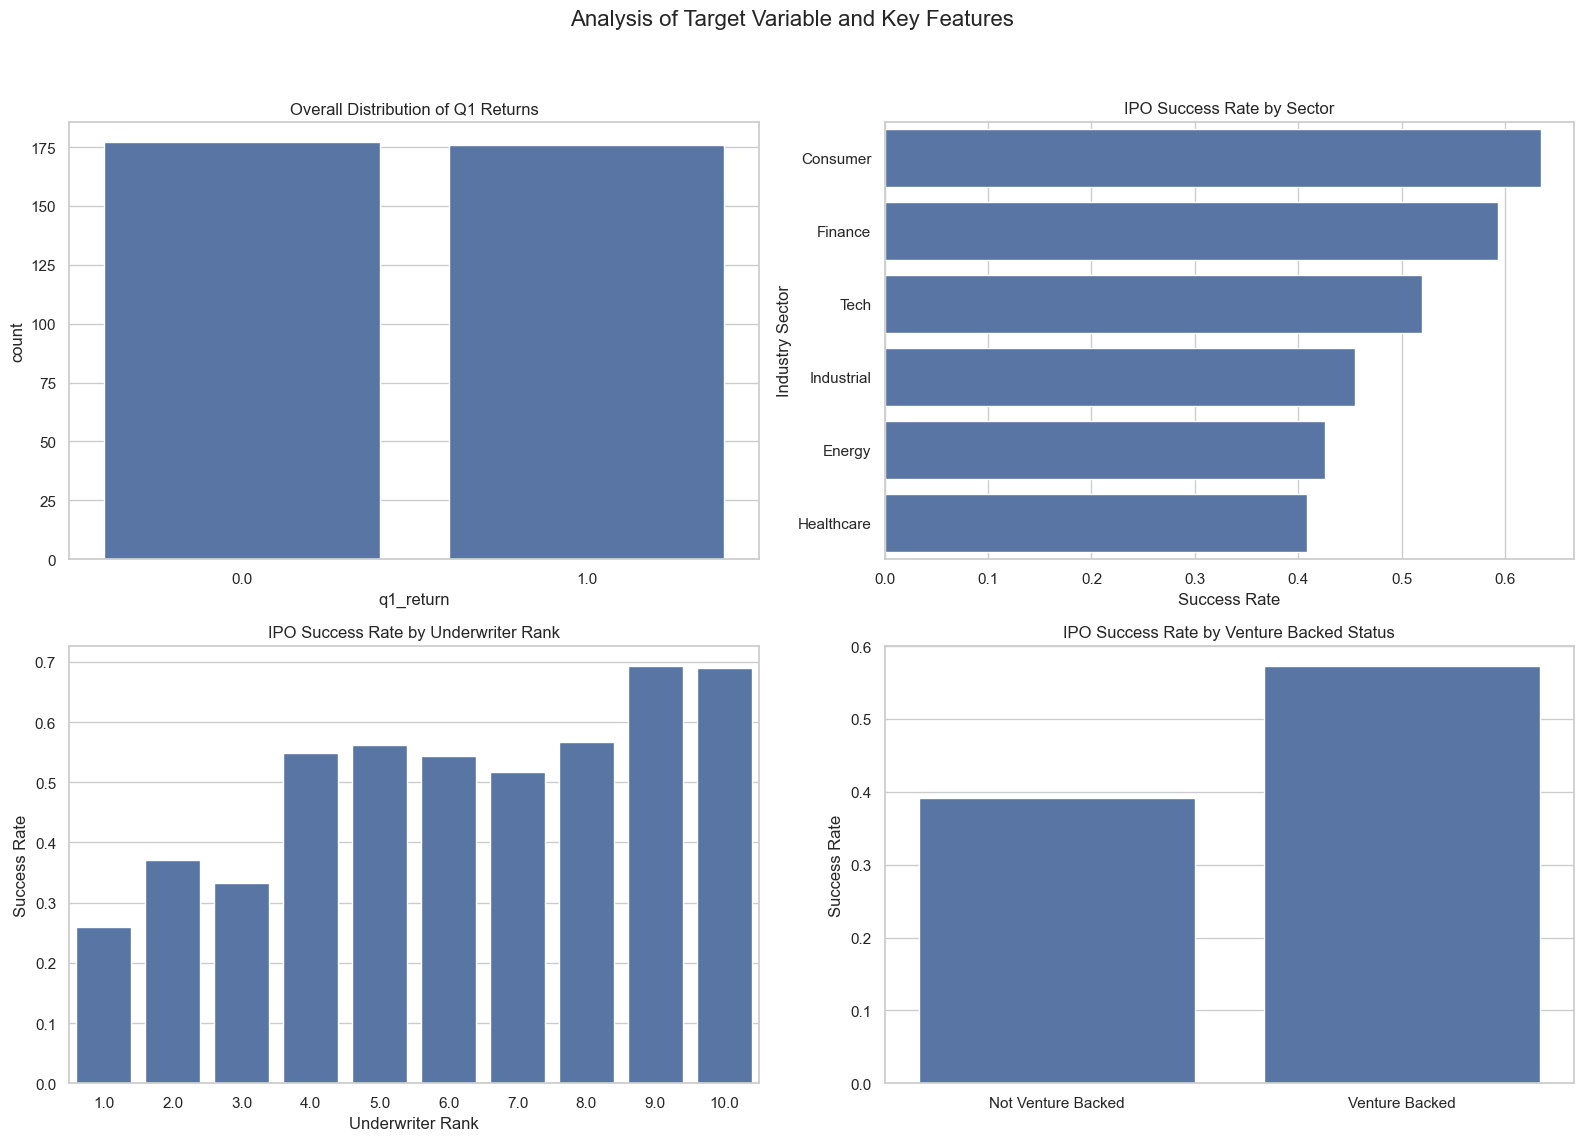

In [5]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analysis of Target Variable and Key Features', fontsize=16)

# Target Variable Distribution
sns.countplot(x=TARGET_COLUMN, data=pipeline.cleaned_data, ax=axes[0, 0])
axes[0, 0].set_title('Overall Distribution of Q1 Returns')

# Successful IPOs by Sector
sector_success_rate = pipeline.cleaned_data.groupby(str(Columns.INDUSTRY_SECTOR))[TARGET_COLUMN].mean().sort_values(ascending=False)
sns.barplot(y=sector_success_rate.index, x=sector_success_rate.values, ax=axes[0, 1], orient='h')
axes[0, 1].set_title('IPO Success Rate by Sector')
axes[0, 1].set_xlabel('Success Rate')
axes[0, 1].set_ylabel('Industry Sector')

# Successful IPOs by Underwriter Rank
rank_success_rate = pipeline.cleaned_data.groupby(str(Columns.UNDERWRITER_RANK))[TARGET_COLUMN].mean()
sns.barplot(x=rank_success_rate.index, y=rank_success_rate.values, ax=axes[1, 0])
axes[1, 0].set_title('IPO Success Rate by Underwriter Rank')
axes[1, 0].set_ylabel('Success Rate')
axes[1, 0].set_xlabel('Underwriter Rank')

# Successful IPOs by Venture Backed Status
venture_success_rate = pipeline.cleaned_data.groupby(str(Columns.VENTURE_BACKED))[TARGET_COLUMN].mean()
sns.barplot(x=venture_success_rate.index, y=venture_success_rate.values, ax=axes[1, 1])
axes[1, 1].set_title('IPO Success Rate by Venture Backed Status')
axes[1, 1].set_ylabel('Success Rate')
axes[1, 1].set_xticks([0, 1])
axes[1, 1].set_xticklabels(['Not Venture Backed', 'Venture Backed'])
axes[1, 1].set_xlabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

**Note:** The plots above show a clear trend where IPO success rate is higher for higher-ranked underwriters. This suggests that `underwriter_rank` will likely be a significant predictive feature in our models. The data also appears reasonably balanced with respect to the target variable. There are also hints of venture backed IPOs & some specific industry sector IPOs doing well but because of the lack of enough data, it is difficult to make definite conclusions.

## 2. Feature Engineering

Here the feature types are defined & new features from the existing data are created.

### Step 2.1: Define Feature Types

In [6]:
pipeline.define_feature_types()


--- Defining Feature Types ---
Manually defined categorical features: ['industry_sector', 'venture_backed', 'ipo_month', 'lockup_period_days']
Remaining numerical features: ['company_age', 'employees', 'revenue_millions', 'revenue_growth_rate', 'ebitda_margin', 'offer_price', 'shares_offered_millions', 'underwriter_rank', 'market_volatility_index', 'sector_performance_30d']


### Step 2.2: Create New Features

Two new features are created to better capture company scale and efficiency:
- **`ipo_size_M`**: This represents the total deal size of the IPO (`offer_price` * `shares_offered_millions`).
- **`revenue_per_employee`**: This creates a simple measure of employee efficiency (`revenue_millions` / `employees`).

In [7]:
pipeline.create_new_features()


--- Creating New Features ---
Creating new features: [ipo_size_M, revenue_per_employee]
New features created. Numerical features are now: ['company_age', 'employees', 'revenue_millions', 'revenue_growth_rate', 'ebitda_margin', 'offer_price', 'shares_offered_millions', 'underwriter_rank', 'market_volatility_index', 'sector_performance_30d', 'ipo_size_M', 'revenue_per_employee']


### Step 2.3: Apply Log Transformations

Some numerical features are highly skewed (e.g., company financials). Applying a log transformation helps to normalize their distribution, which can improve the performance of some models, particularly linear ones like Logistic Regression. The features to which this information is applied are picked up automatically by calculating the skew values.

In [8]:
pipeline.apply_log_transform()


--- Applying Log Transformations ---
Applying log transform to highly skewed features: ['company_age', 'employees', 'revenue_millions', 'offer_price', 'shares_offered_millions', 'ipo_size_M', 'revenue_per_employee']


### Step 2.4: Final Transformations (Imputation, Encoding & Standardization)

Imputing missing values & converting categorical features to a numerical format (One-Hot Encoding)—are bundled directly into the modeling pipeline to avoid data leakage. Numerical features are also standardized using `StandardScaler` to ensure they are on a comparable scale (mean 0 & standard deviation 1).

## 3. Model Development

Splitting data in train (80%) & hold-out (20%). All the results will be presented on the hold-out data-set.

In [9]:
pipeline.split_data()


--- Splitting Data into Train/Test Sets ---
Training/Validation set size: 282
Hold-out Test set size: 71


### Training Model 1: Logistic Regression

In [10]:
pipeline.train_and_evaluate_single_model(Models.LOGISTIC)


==================== Training & Evaluating: LOGISTIC ====================
--- Running Stratified K-Fold CV for logistic ---
Mean ROC AUC: 0.8172 (SEM: 0.0209)
--- Training final logistic model ---
Training complete.
--- Generating Feature Importance for logistic ---
--- Finished workflow for logistic ---


### Training Model 2: XGBoost

In [11]:
pipeline.train_and_evaluate_single_model(Models.XGB)


==================== Training & Evaluating: XGB ====================
--- Running Stratified K-Fold CV for xgb ---
Mean ROC AUC: 0.7268 (SEM: 0.0230)
--- Training final xgb model ---
Training complete.
--- Generating Feature Importance for xgb ---
--- Finished workflow for xgb ---


## 4. Results on Test Data

### Cross-Validation Mean ROC AUC (from Training Set)

In [12]:
for model_name in pipeline.cv_results:
    mean_auc = pipeline.cv_results[model_name]
    sem_auc = pipeline.cv_results_sem[model_name]
    print(f"Mean CV ROC AUC for {model_name}: {mean_auc:.4f} ± {sem_auc:.4f}")

Mean CV ROC AUC for logistic: 0.8172 ± 0.0209
Mean CV ROC AUC for xgb: 0.7268 ± 0.0230


### Classification Reports on Hold-out Test Set

In [13]:
for model_name, report in pipeline.holdout_reports.items():
    print(f'\n--- Classification Report for {model_name} ---')
    print(report)


--- Classification Report for logistic ---
              precision    recall  f1-score   support

         0.0       0.79      0.75      0.77        36
         1.0       0.76      0.80      0.78        35

    accuracy                           0.77        71
   macro avg       0.78      0.78      0.77        71
weighted avg       0.78      0.77      0.77        71


--- Classification Report for xgb ---
              precision    recall  f1-score   support

         0.0       0.72      0.58      0.65        36
         1.0       0.64      0.77      0.70        35

    accuracy                           0.68        71
   macro avg       0.68      0.68      0.67        71
weighted avg       0.68      0.68      0.67        71



### Confusion Matrices on Hold-out Test Set

The confusion matrices below display the proportion of actual labels, normalized by row, for each predicted class.

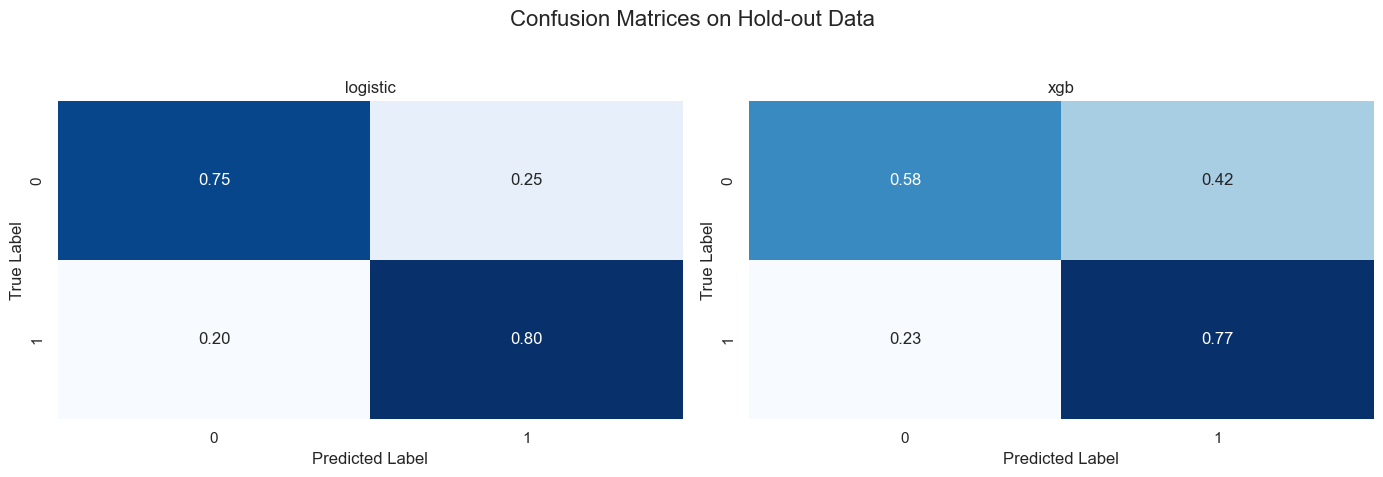

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Confusion Matrices on Hold-out Data', fontsize=16)

for i, (model_name, matrix) in enumerate(pipeline.holdout_matrices.items()):
    ax = axes[i]
    # Normalize the confusion matrix to show fractions
    # Each row sums to 1, representing the proportion of true labels predicted as each class
    matrix_normalized = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sns.heatmap(matrix_normalized, annot=True, fmt='.2f', cmap='Blues', ax=ax, cbar=False)
    ax.set_title(f'{model_name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Interpreting the Confusion Matrix

- **Top-Left (True Negative):** The model correctly predicted an IPO would *not* have a positive Q1 return.
- **Bottom-Right (True Positive):** The model correctly predicted an IPO *would* have a positive Q1 return.
- **Top-Right (False Positive):** The model predicted a positive return, but it was actually negative.
- **Bottom-Left (False Negative):** The model predicted a negative return, but it was actually positive.

### ROC Curve Comparison

Logistic regerssion clearly performs better compared to XGBoost which is not expected as XGBoost is non-linear model & with very limited data (400 samples in total), the chances of overfitting with a non-linear model are much higher.

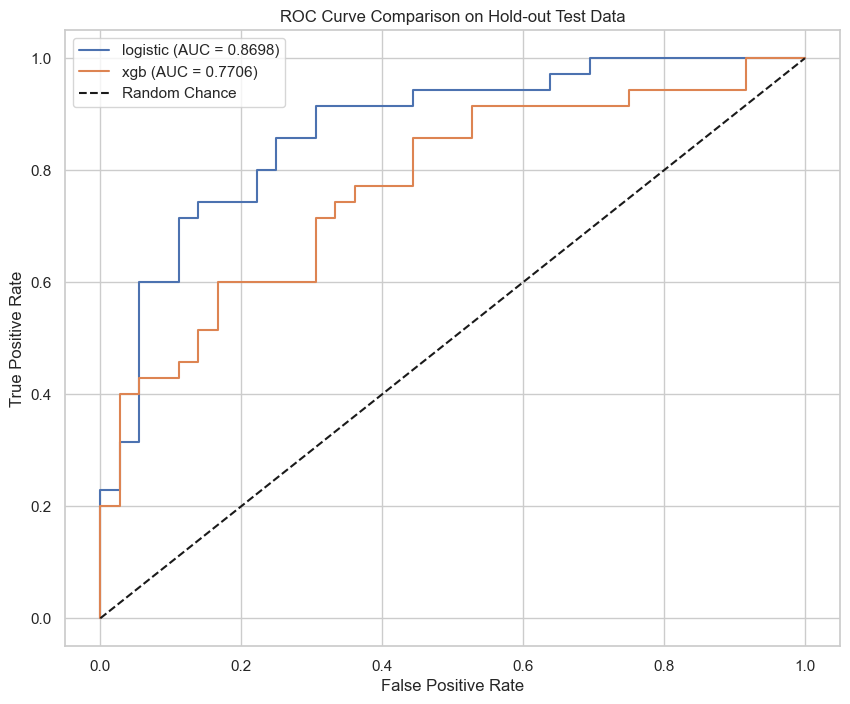

In [15]:
pipeline._plot_combined_roc_curve()

### Feature Importance Comparison

Following plots show the normalized feature importances (they sum to 1).

* Logistic Regression: For this linear model, importance is derived from the absolute value of its coefficients. A larger absolute coefficient indicates a greater impact on the predicted outcome.
* XGBoost: As a complex, non-linear model, XGBoost requires a more sophisticated approach. SHAP (SHapley Additive exPlanations) is used here. It calculates how much each feature "pushes" the prediction from the average.

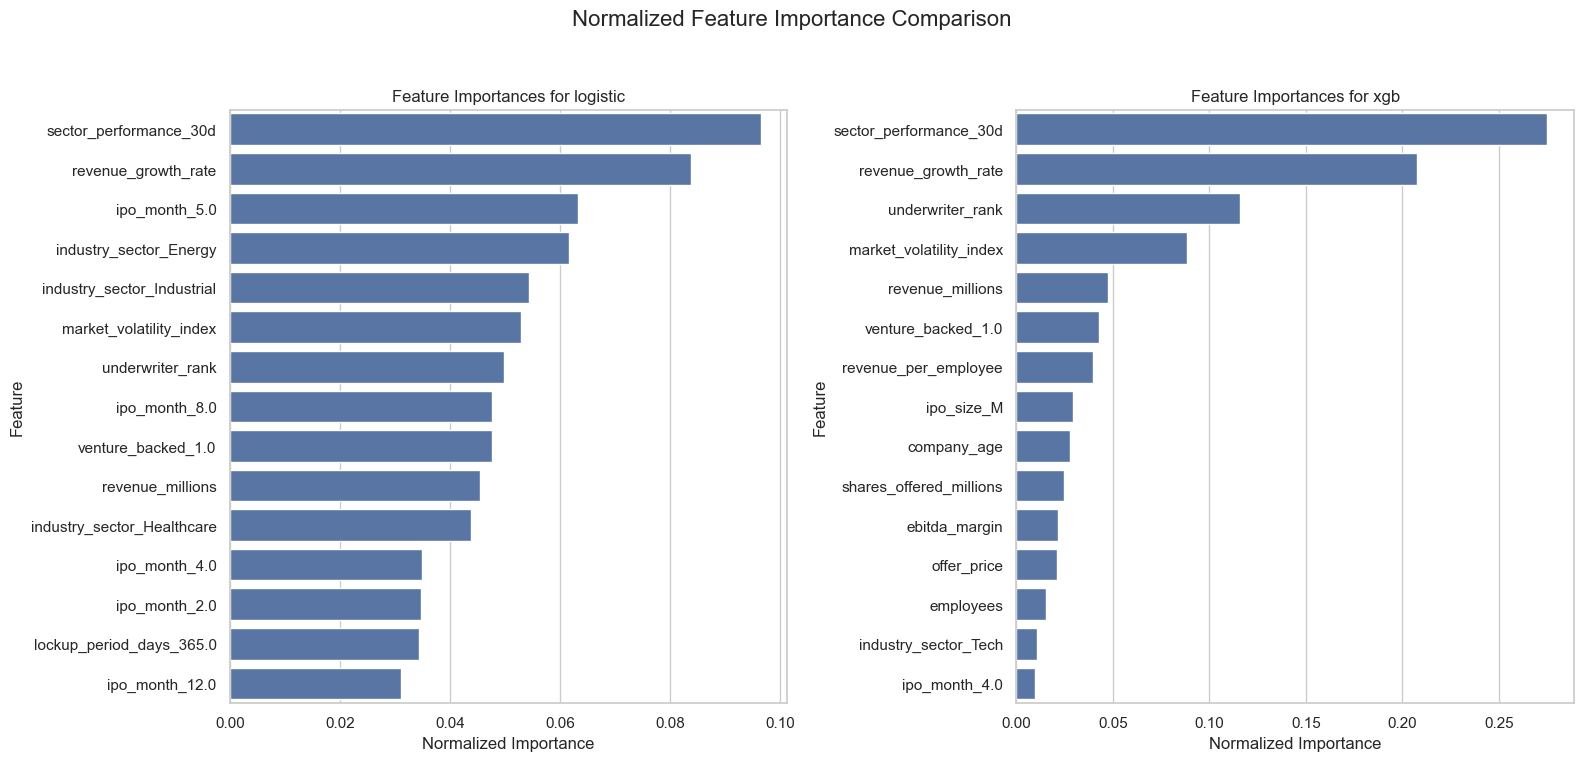

In [16]:
pipeline._plot_feature_importances()

## 5. Business Communication

### Model Recommendation

While both models perform well, **Logistic Regression is the recommended model**. It achieves better, cross-validation score and performance on the hold-out test set compared to XGBoost. Given that it is also a much simpler and more interpretable model, it is a better choice for this business problem.

### Top Features & Business Insights (from Logistic Regression)

Based on our recommended model, the most influential features are:
1.  **`sector_performance_30d`:** The recent performance of the company's sector is a consistently strong predictor. IPOs in sectors with positive momentum tend to perform better.
2.  **`revenue_growth_rate`:** Companies with higher revenue growth rates have higher chance of a successful IPO which isn't unexpected.
3.  **`ipo_month_5.0`:** IPOs launched in October show a notable impact on Q1 returns.

**Key Business Insight:** A primary takeaway is to prioritize or focus on sectors & companies that have performed well more recently. **`market_volatility_index`** also ranks very highly with the performance being negatively correlated to it. All these factor hint towards a large depedence on the overall market & sector dynamics on the IPO. **`underwriter_rank`** is also ranked fairly highly & therefore deals led by **higher-ranked underwriters** have a demonstrably higher success rate according to the model as well as exploratory data analysis.

### Next Steps

To further enhance the model and its utility:
1.  **More Data:** Acquire additional historical IPO data, especially from different market cycles (e.g., recessions, bull markets), to improve model robustness. This is particularly important in order to use non-linear models like XGBoost as they require a lot more data than linear models because of their complexity.
2.  **Hyperparameter Tuning:** Systematically optimize the hyperparameters of XGBoost using techniques like GridSearchCV or RandomizedSearchCV to see if its performance can be pushed beyond the Logistic Regression baseline.
3.  **Additional Features:** Explore new economically relevant features such as broader market indices (e.g., S&P 500 performance) or interest rate levels.
4.  **Categorical Features:** Investigate advanced categorical encoding techniques, such as target encoding, to potentially enhance model performance and robustness.
5.  **Early Stopping:** Implement early stopping mechanisms for XGBoost to prevent overfitting and optimize training duration.

### Model Limitations

It's important to acknowledge the limitations of the current model:
1.  **Dataset Size:** The model is trained on a relatively small dataset (~400 IPOs), which will limit its ability to generalize.
2.  **Binary Target Variable:** The current model predicts a binary outcome: whether the Q1 return is positive or not. This simplification loses valuable information. For instance, it treats a +1% return and a +50% return as the same "success".
3.  **Market Dynamics:** The model is based on historical data and may not fully capture sudden shifts in market dynamics or unforeseen economic events. A model trained on data from one period may not perform as well in a different market regime.